<a href="https://colab.research.google.com/github/daniilwithangelic/veb_program/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# МЛ Практика 4: Задача классификации

## **Цель занятия:**
Изучить задачу классификации, познакомиться с метриками качества, реализовать классификатор с использованием разных моделей.

## **Задание состоит из следующих частей:**
1. Отбор признаков
2. Обучение классификатора
3. Обработка "переобучения" и дисбаланс классов и как с этим жить
4. Метирки качества и что это все означает
5. Задача мультиклассовой классификации
6. Дерево принятия решений

# ⏰ Домашнее задание

- 1. Выбрать пременную для задачи бинарной классификации (назовем это x_binary, y_binary) и выбрать пременные для задачи мультиклассовой классификации (назовем это x_multi, y_multi)

p.s. если использовали произвольную пременную для binary, multiclassification - не зывбаем выбрасывать из X изначальную переменную

- 2. Решить задачу классификации с использованием кросс валидации, оценить метрики качства: accuracy, precision, recall (включая classification report).
  - 2.1. Используя опыт прошлых работ, попробуйте использовать лучшие признаки для решения задачи

- 3. Для обоих задач побороться с дисбалансом классов следующими техниками:
  - oversampling (например, SMOTE)
  - или undersampling.

Для oversampling и undersampling используйте (https://imbalanced-learn.org/)
Опишите полученный результат

Самый простой пример (желательно не использовать рандом)
```
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
```

- 4. Обучить дерево принятия решений с использованием кросс-валидации (Stratify K-fold и/или StratifyRandomShuffle)  для ```oversampling``` и ```undersampling``` (в задачи мультиклассовой классификации), оценить метрики и описать результат.



## 1: Загрузка библиотек и предобратка данных

In [1]:
!pip install pandas scikit-learn seaborn scipy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/income.csv')

df['workhorse'] = np.where(df['hours-per-week'] >= 40, 1, 0)
df.workhorse = df.workhorse.astype('category')
df['race'] = df['race'].astype('category')

y = df['workhorse'] # выбираем целевую переменную (категориальную)
X = df.drop('workhorse', axis=1) # переменные для проверки влияния

# В моем случае я дропаю базовую переменную, а не только. Y
X = X.drop('hours-per-week', axis=1)
df.drop('hours-per-week', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       30725 non-null  object  
 2   education       32561 non-null  object  
 3   education-num   32561 non-null  int64   
 4   marital-status  32561 non-null  object  
 5   occupation      30718 non-null  object  
 6   relationship    32561 non-null  object  
 7   race            32561 non-null  category
 8   sex             32561 non-null  object  
 9   capital-gain    32561 non-null  int64   
 10  capital-loss    32561 non-null  int64   
 11  native-country  31978 non-null  object  
 12  income >50K     32561 non-null  int64   
 13  workhorse       32561 non-null  category
dtypes: category(2), int64(5), object(7)
memory usage: 3.0+ MB


In [3]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


### 1.2 Проверка баланса

Проверка, насколько сбалансированы классы в нашей целевой переменной:

In [4]:
y.value_counts()

,count
workhorse,
1,24798
0,7763


### 1.3 Создание искусственного дисбаланса классов
Создадим новую целевую переменную y_disbalanced, где 90% классов будут 0, а 10% — 1:

In [5]:
from sklearn.utils import resample

# Объединяем X и y для удобства
data = pd.concat([X, y], axis=1)

# Разделяем на классы
majority = data[data['workhorse'] == 0]
minority = data[data['workhorse'] == 1]

# Уменьшаем количество экземпляров класса 1
minority_downsampled = resample(minority,
                                replace=False,
                                n_samples=int(len(majority)*0.1),
                                random_state=42)

# Объединяем обратно
data_disbalanced = pd.concat([majority, minority_downsampled])

# Новые X и y
X_disbalanced = data_disbalanced.drop('workhorse', axis=1)
y_disbalanced = data_disbalanced['workhorse']


Проверим новый баланс классов:

In [6]:
print(y_disbalanced.value_counts())


workhorse
0    7763
1     776
Name: count, dtype: int64


###1.4 Обучаем логистическую регрессию (без доп. манипуляций) на дисбалансе

In [7]:
# Преобразование категориальных признаков
# Преобразуем логические столбцы в целые числа
boolean_columns = X_disbalanced.select_dtypes(include=['bool']).columns
for col in boolean_columns:
    X_disbalanced[col] = X_disbalanced[col].astype(int)

# Теперь применяем One-Hot Encoding к категориальным переменным
X_disbalanced = pd.get_dummies(X_disbalanced, drop_first=True)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_disbalanced, y_disbalanced, test_size=0.3, random_state=42)

# Обучаем модель
model = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)


In [8]:
from sklearn.metrics import classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9082747853239657

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95      2327
           1       0.00      0.00      0.00       235

    accuracy                           0.91      2562
   macro avg       0.45      0.50      0.48      2562
weighted avg       0.82      0.91      0.86      2562



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
unique, counts = np.unique(y_pred, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # данная ситуация называется переобучением. Модель очень хорошо обучилась на 0, настолько, что не может предсказать 1

{0: 2562}

### 1.5 Создадим сбалансированную выборку, и попробуем сделать тоже самое

In [10]:
from sklearn.utils import resample
import pandas as pd

# Предполагаем, что у вас уже есть DataFrame `data`
# Разделяем на классы
majority = data[data['workhorse'] == 0]
minority = data[data['workhorse'] == 1]

# Определяем количество экземпляров в меньшинственном классе
n_samples = len(minority)  # Используем размер меньшинственного класса

# Проверяем, что размер большинства больше размера меньшинства
if len(majority) > n_samples:
    # Уменьшаем количество экземпляров класса 0 до размера меньшинственного класса
    majority_downsampled = resample(majority,
                                     replace=False,
                                     n_samples=n_samples,  # Устанавливаем n_samples равным размеру меньшинственного класса
                                     random_state=42)

    # Объединяем обратно
    data_balanced = pd.concat([majority_downsampled, minority])
else:
    # Если размер большинства меньше или равен меньшинству, просто используем большинство
    data_balanced = data

# Новые X и y
X_balanced = data_balanced.drop('workhorse', axis=1)
y_balanced = data_balanced['workhorse']

In [11]:
print(y_balanced.value_counts())


workhorse
1    24798
0     7763
Name: count, dtype: int64


In [12]:
# Преобразование категориальных признаков
# Преобразуем логические столбцы в целые числа
boolean_columns = X_balanced.select_dtypes(include=['bool']).columns
for col in boolean_columns:
    X_balanced[col] = X_balanced[col].astype(int)

# Теперь применяем One-Hot Encoding к категориальным переменным
X_balanced = pd.get_dummies(X_balanced, drop_first=True)

# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [13]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal))


Accuracy: 0.7649708260825059

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2296
           1       0.76      1.00      0.87      7473

    accuracy                           0.76      9769
   macro avg       0.38      0.50      0.43      9769
weighted avg       0.59      0.76      0.66      9769



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{1: 9769}

In [15]:
# Выбираем числовые признаки
numeric_features = X_balanced.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
X_balanced[numeric_features] = scaler.fit_transform(X_balanced[numeric_features])


In [16]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [17]:
print("Accuracy:", accuracy_score(y_test_bal, y_pred_bal))
print("\nClassification Report:\n", classification_report(y_test_bal, y_pred_bal)) # Дополнительно получили 1.57% точности, отлично!


Accuracy: 0.7894359709284471

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.32      0.42      2296
           1       0.82      0.93      0.87      7473

    accuracy                           0.79      9769
   macro avg       0.71      0.63      0.64      9769
weighted avg       0.77      0.79      0.76      9769



In [18]:
unique, counts = np.unique(y_pred_bal, return_counts=True) # получаем уникальные значения и их количество в предсказанных данных

dict(zip(unique, counts)) # Текущая модель показывает неплохие результаты. Попробуем улучшить

{0: 1225, 1: 8544}

# 2 Метрики качества классификаци

Приведу разбор метрик классификации с аналогиями, используя пример с яблоками разных цветов 🍏🍎. Представьте, что задача — правильно определить, какие яблоки зеленые, красные или желтые. Каждая метрика поможет оценить, насколько хорошо мы справляемся с этой задачей.

То есть, есть Y, который состоит из яблок разных цветов
- 1 🍏 - класс 0
- 2 🍎 - класс 1

Прежде чем перейти к метрикам, важно понять, что означают обозначения TP, FP, TN, FN. Они представляют разные типы предсказаний:

- TP (True Positive) — правильно предсказанные положительные примеры (например, если мы верно определили 🍏 как зеленое яблоко).

- FP (False Positive) — ошибочно предсказанные положительные примеры (например, если мы предсказали 🍎 как 🍏).

- TN (True Negative) — правильно предсказанные отрицательные примеры (например, если мы верно определили, что 🍎 не является 🍏).

- FN (False Negative) — ошибочно предсказанные отрицательные примеры (например, если мы не определили 🍏 как зеленое яблоко, хотя оно таким является).

### 2.1 Точность (Accuracy)


Формула:
Accuracy = (TP + TN) / (TP + FP + TN + FN)

Пример:
У нас 10 яблок: 4 🍏, 3 🍎, 3 🍊. Алгоритм правильно предсказал 7 из них.
Accuracy = 7 / 10 = 0.7 или 70%

**Когда использовать**:
Точность полезна, когда классы сбалансированы (примерно равное количество примеров каждого типа). В случаях сильного дисбаланса классов, точность может стать вводящей в заблуждение, так как она не учитывает, что какой-то класс может преобладать.

### 2.2 Precision и Recall

- Precision (Точность) — процент верных положительных предсказаний среди всех предсказанных положительных.
- Recall (Полнота) — процент верных положительных предсказаний среди всех фактических положительных случаев.

Формулы:
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

Пример:
Мы пытаемся предсказать 🍏 (зеленое яблоко).

У нас 5 🍏, из них 4 правильно определены как 🍏, но 1 🍎 ошибочно классифицировано как 🍏.
- Precision для 🍏: 4 / (4 + 1) = 0.8 или 80%
- Recall для 🍏: 4 / (4 + 1) = 0.8 или 80%

**Когда использовать**:

Precision важен, когда критично избежать ложных положительных предсказаний (например, если ошибочно отнесенные яблоки могут повлиять на качество товара).
Recall важен, когда критично найти все положительные примеры (например, если требуется найти все 🍏 в ящике, чтобы их не упустить).

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" height=800 />

### 2.3. F1-score


F1-score — это гармоническое среднее между Precision и Recall, что позволяет учитывать как ложноположительные, так и ложноотрицательные предсказания.

Формула:
- F1 = 2 * (Precision * Recall) / (Precision + Recall)

Пример:

Если Precision = 80% и Recall = 80%, то:
F1 = 2 * (0.8 * 0.8) / (0.8 + 0.8) = 0.8 или 80%

**Когда использовать**:
F1-score полезен, когда требуется балансировать между Precision и Recall, особенно при наличии дисбаланса классов. Он важен, когда критично учитывать и ложные положительные, и ложные отрицательные предсказания.

### 2.4. ROC-AUC
ROC-кривая показывает, как меняется соотношение между True Positive Rate (доля правильно предсказанных положительных) и False Positive Rate (доля ошибочно предсказанных положительных) при разных порогах. AUC (площадь под ROC-кривой) измеряет общую способность модели различать классы.

Когда использовать:
ROC-AUC используется для оценки моделей, когда требуется понять способность модели различать классы в задаче классификации. Чем ближе AUC к 1, тем лучше модель. AUC особенно полезен, когда классы несбалансированы, так как он показывает общую производительность модели при разных порогах.

ROC-кривая (Receiver Operating Characteristic) отображает зависимость между:

- True Positive Rate (TPR) — это доля правильно предсказанных положительных примеров среди всех фактических положительных примеров.
Формула: TPR = TP / (TP + FN)

- False Positive Rate (FPR) — это доля ошибочно предсказанных положительных примеров среди всех фактических отрицательных примеров.
Формула: FPR = FP / (FP + TN)

На графике ROC:

- Ось Y представляет TPR (доля верных положительных предсказаний).
- Ось X представляет FPR (доля ошибочных положительных предсказаний).

AUC (Area Under Curve) — это площадь под ROC-кривой. Она измеряет способность модели различать классы: чем больше площадь (чем ближе AUC к 1), тем лучше модель справляется с разделением классов.

- AUC = 1 — идеальная модель: она всегда отличает положительный класс от отрицательного.
- AUC = 0.5 — случайное угадывание, модель не способна различать классы лучше, чем просто случайный выбор.

[Подробнее](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=ru)

### 2.5 Classification Report

### Classification Report (на примере 🍏 и 🍎):

|               | Precision | Recall | F1-score | Support |
|---------------|-----------|--------|----------|---------|
| **0 (🍏)**    | 0.78      | 0.73   | 0.75     | 390     |
| **1 (🍎)**    | 0.74      | 0.79   | 0.76     | 377     |
| **Accuracy**  |           |        | 0.76     | 767     |
| **Macro avg** | 0.76      | 0.76   | 0.76     | 767     |
| **Weighted avg** | 0.76   | 0.76   | 0.76     | 767     |

---

1. **Precision**:
   - **🍏 (0.78)** — 78% предсказанных 🍏 действительно 🍏.
   - **🍎 (0.74)** — 74% предсказанных 🍎 действительно 🍎.

2. **Recall**:
   - **🍏 (0.73)** — модель нашла 73% всех 🍏.
   - **🍎 (0.79)** — модель нашла 79% всех 🍎.

3. **F1-score**:
   - **🍏 (0.75)**, **🍎 (0.76)** — баланс Precision и Recall для каждого класса.

4. **Accuracy** = 0.76 — 76% всех предсказаний правильны.


### 2.6 А теперь до делу (вернемся к прошлым примерам и проанализуем нашу ситуацию)

In [19]:
# Разделяем данные
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Обучаем модель
model_balanced = LogisticRegression(penalty=None, solver='saga', max_iter=10000)
model_balanced.fit(X_train_bal, y_train_bal)

# Предсказания
y_pred_bal = model_balanced.predict(X_test_bal)


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# Вычисляем матрицу ошибок (TP, FP, TN, FN)
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)
tn, fp, fn, tp = conf_matrix.ravel()

# Рассчитываем метрики
accuracy = accuracy_score(y_test_bal, y_pred_bal)
precision = precision_score(y_test_bal, y_pred_bal)
recall = recall_score(y_test_bal, y_pred_bal)
f1 = f1_score(y_test_bal, y_pred_bal)
roc_auc = roc_auc_score(y_test_bal, y_pred_bal)

# Генерируем classification_report
class_report = classification_report(y_test_bal, y_pred_bal, output_dict=True)

# Формируем результаты для наглядного вывода
results = {
    "True Negatives (TN)": tn,
    "False Positives (FP)": fp,
    "False Negatives (FN)": fn,
    "True Positives (TP)": tp,
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1,
    "ROC-AUC": roc_auc,
}

# Округляем все значения в словаре до двух знаков после запятой и возвращаем в виде dict.items()
rounded_items = {k: round(v, 2) for k, v in results.items()}


⏰ оцениваем метрики и объясняем результат (без ChatGPT)
1.	Модель правильно классифицирует 79% всех примеров( accuracy).
2.	Высокая точность предсказания первого класса 82%(предсказаных/тестовых)
3.	Еще более высокий процент предсказания 93% (фактических)
4.	Модель имеет хороший баланс между положительным и отрицательными предсказываниями 87%.
5.	Плохо пердсказывается класс 0  precision составляет 60% и recall 32%. Возможно говорит о малом количестве данных для этого класса.
## **Выводы из матрицы:**
* Модель правильно распознала 732 примера класса 0.
* Модель плохо обучилась для предсказывания класса 0, так как 1564 примера ошибочно классифицировала.
*	Модель сделала меньше ошибок для класса 	1 (493).
*	Правильно предсказала 6980 для класса 1.


In [21]:
print(classification_report(y_test_bal, y_pred_bal))

              precision    recall  f1-score   support

           0       0.60      0.32      0.42      2296
           1       0.82      0.93      0.87      7473

    accuracy                           0.79      9769
   macro avg       0.71      0.63      0.64      9769
weighted avg       0.77      0.79      0.76      9769



In [22]:
conf_matrix # Матрица
# TN FP
# FN TP

array([[ 732, 1564],
       [ 493, 6980]])

In [23]:
rounded_items

{'True Negatives (TN)': 732,
 'False Positives (FP)': 1564,
 'False Negatives (FN)': 493,
 'True Positives (TP)': 6980,
 'Accuracy': 0.79,
 'Precision': 0.82,
 'Recall': 0.93,
 'F1-score': 0.87,
 'ROC-AUC': 0.63}

# 3. Задача мультиклассовой классфикации

Задача мультиклассовой классификации - когда мы хотим предсказать сразу несколько классов

В качестве y - используем quality

In [24]:
y = df['hours-per-week']

X = df.drop(['hours-per-week', 'workhorse'], axis=1)

In [25]:
# Создаем копию данных
category_columns: list[str] = X.select_dtypes(include=['category']).columns # собираем колонки помеченные как category

# Применяем One-Hot Encoding
X = pd.get_dummies(X, columns=category_columns,drop_first=True) # drop_first=True позволяет избежать мультиколлинеарности, удаляя первый уровень категориальной переменной.


In [26]:
X

,age,workclass,education,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,native-country,income >50K,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,United-States,0,False,False,False,True
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,United-States,0,False,False,False,True
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,United-States,0,False,False,False,True
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,United-States,0,False,True,False,False
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,Cuba,0,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,Female,0,0,United-States,0,False,False,False,True
32557,40,Private,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,Male,0,0,United-States,1,False,False,False,True
32558,58,Private,HS-grad,9,Widowed,Adm-clerical,Unmarried,Female,0,0,United-States,0,False,False,False,True
32559,22,Private,HS-grad,9,Never-married,Adm-clerical,Own-child,Male,0,0,United-States,0,False,False,False,True


## 3.1 Алгоритм дерева принятия решений

Алгоритм дерева принятия решений (Decision Tree) — это один из методов машинного обучения, который используется для решения задач классификации и регрессии. Дерево решений представляет собой структуру, в которой каждый внутренний узел соответствует некоторому признаку, а каждая ветвь — определенному значению этого признака. Листовые узлы представляют собой классы или значения, которые необходимо предсказать.

### Как работает дерево решений:

1. **Корневой узел**: Это первый узел в дереве, который соответствует самому информативному признаку. Признак выбирается на основе критериев, например по индексу Gini (различие по y, чем ближе к 1, тем разнороднее классы y в узле)

2. **Разбиение данных**: На каждом шаге дерево разбивает данные на подмножества в соответствии с выбранным признаком. Эти разбиения происходят рекурсивно, пока не будет достигнут некоторый критерий остановки (например, максимальная глубина дерева, минимальное количество данных в листе).

3. **Листовые узлы**: Листовые узлы содержат финальные предсказания. В случае задачи классификации это будет класс, а в случае регрессии — числовое значение.

4. **Критерии остановки**: Дерево останавливает разбиение, если достигается один из критериев остановки — например, если достигнута максимальная глубина дерева или в узле осталось меньше минимального числа данных для разбиения.

### Преимущества:
- Простота визуализации и интерпретации.
- Может использоваться как для классификации, так и для регрессии.
- Не требует предварительной нормализации данных.

### Недостатки:
- Может переобучаться (overfitting), если не ограничить глубину дерева.
- Чувствительно к небольшим изменениям в данных.

In [27]:
# Преобразование категориальных признаков
# Преобразуем логические столбцы в целые числа
boolean_columns = X.select_dtypes(include=['bool']).columns
for col in boolean_columns:
    X[col] = X[col].astype(int)

# Теперь применяем One-Hot Encoding к категориальным переменным
X = pd.get_dummies(X, drop_first=True)

from sklearn.tree import DecisionTreeClassifier
# Разделяем данные
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем модель
tree_model = DecisionTreeClassifier(random_state=42, max_depth=10)
tree_model.fit(X_train_multi, y_train_multi)

# Предсказания
y_pred_multi = tree_model.predict(X_test_multi)

In [28]:
from sklearn.metrics import classification_report

print("\nClassification Report:\n", classification_report(y_test_multi, y_pred_multi))



Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         6
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         9
           4       0.33      0.05      0.08        21
           5       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00        44
           9       0.00      0.00      0.00         3
          10       0.26      0.08      0.13        83
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00        13
          15       0.08      0.02      0.04       131
          16       0.12      0.03      0.04        76
          17       0.00      0.00      0.00         5
  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Про *macro avg* и *weighted avg*.:

1. **Macro average (macro avg)**:
   - Этот показатель вычисляется как среднее арифметическое по каждому классу для всех метрик (precision, recall и f1-score). То есть сначала вычисляются precision, recall и f1-score для каждого класса, а затем они усредняются без учёта того, сколько примеров было в каждом классе. Этот показатель полезен, когда интересует равное внимание к каждому классу, независимо от его частоты в данных.
   - *Проблема*: Если классы несбалансированы (т.е. некоторые классы имеют намного больше примеров, чем другие), то этот показатель может быть искажен в сторону меньших классов.

2. **Weighted average (weighted avg)**:
   - Этот показатель тоже вычисляется на основе метрик каждого класса (precision, recall и f1-score), но с учетом количества примеров (support) в каждом классе. То есть каждый класс вносит свой вклад в среднее значение пропорционально его количеству примеров в данных.
   - *Преимущество*: В отличие от macro avg, weighted avg корректнее отражает общую производительность модели на несбалансированных данных, так как учитывает частоту каждого класса.

Проще говоря:
- **Macro avg** показывает усреднённое качество модели по всем классам, не обращая внимания на то, сколько примеров в каждом классе.
- **Weighted avg** взвешивает качество по количеству примеров каждого класса, что делает его более устойчивым к несбалансированным классам.

In [29]:
accuracy_score(y_test_multi, y_pred_multi)


0.45828641621455624

In [30]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_multi, y_pred_multi) # ну такое


0.017384947171214346

### Важность признаков

Признаки, которые внесли наибольший вклад в модель

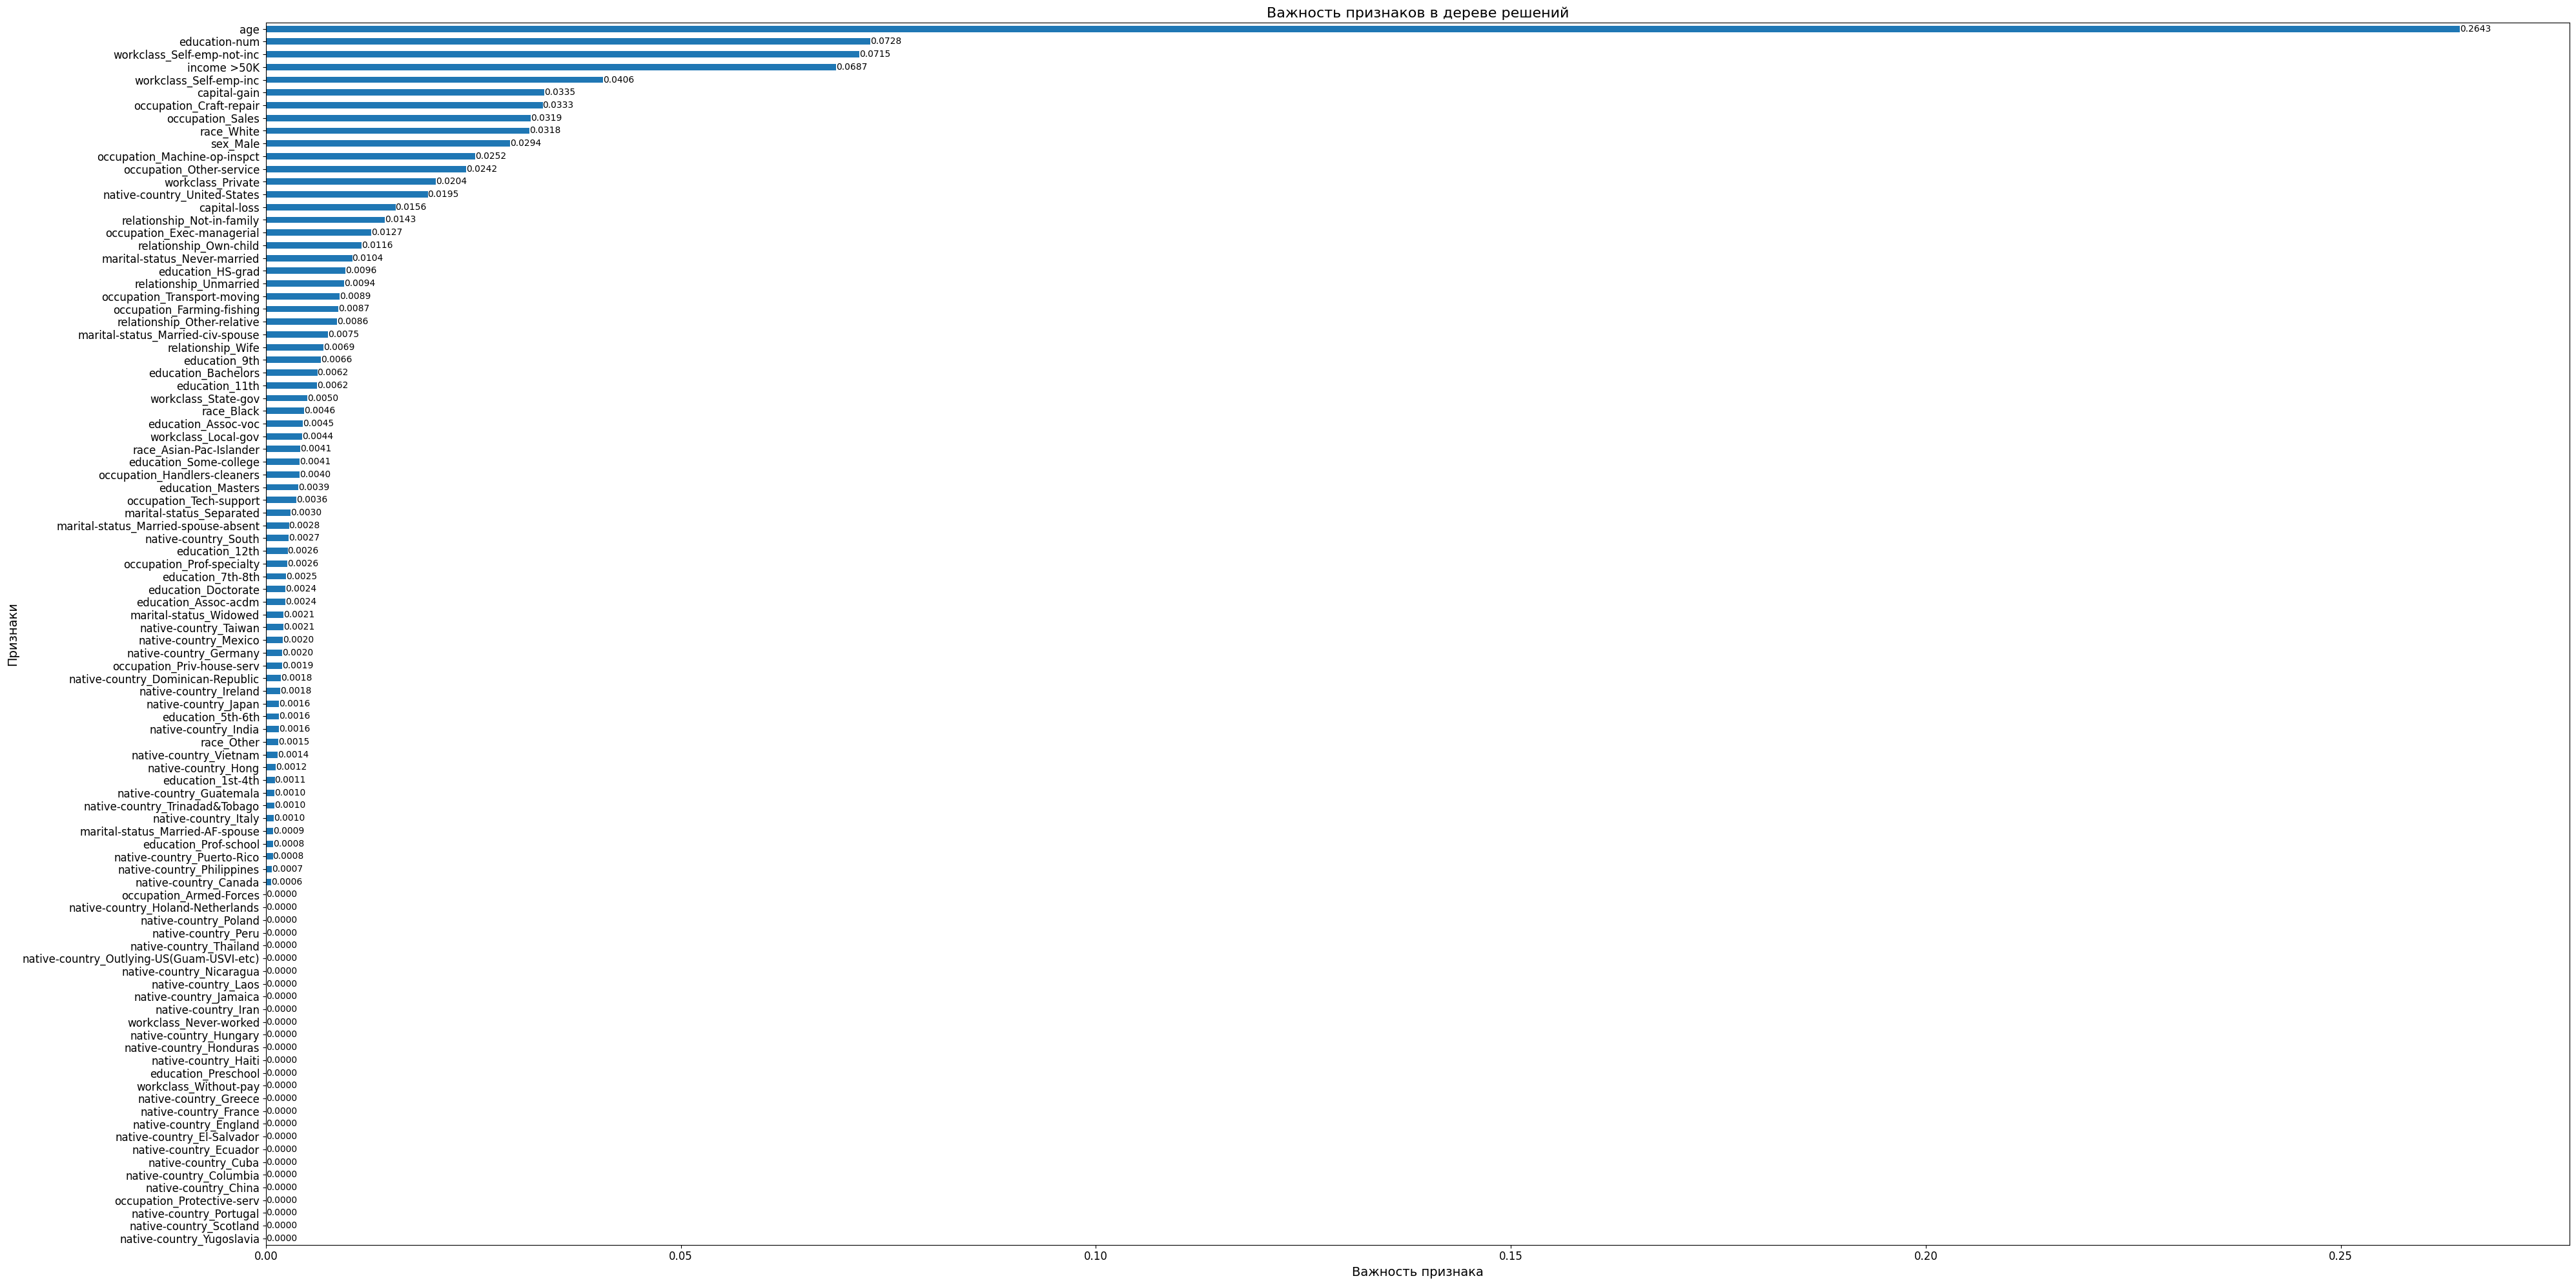

In [40]:
import matplotlib.pyplot as plt
import pandas as pd

# Предполагается, что tree_model и X уже определены
feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh', figsize=(40, 20))  # Увеличиваем размер графика

plt.title('Важность признаков в дереве решений', fontsize=16)  # Увеличиваем размер заголовка
plt.xlabel('Важность признака', fontsize=14)  # Увеличиваем размер подписи оси X
plt.ylabel('Признаки', fontsize=14)  # Увеличиваем размер подписи оси Y
plt.xticks(fontsize=12)  # Увеличиваем размер шрифта для меток на оси X
plt.yticks(fontsize=12)  # Увеличиваем размер шрифта для меток на оси Y

# Добавление аннотаций для каждой полосы
for index, value in enumerate(feature_importances.sort_values()):
    plt.text(value, index, f'{value:.4f}', fontsize=10, va='center')  # Добавляем значение важности

plt.tight_layout()  # Автоматическая настройка отступов
plt.show()


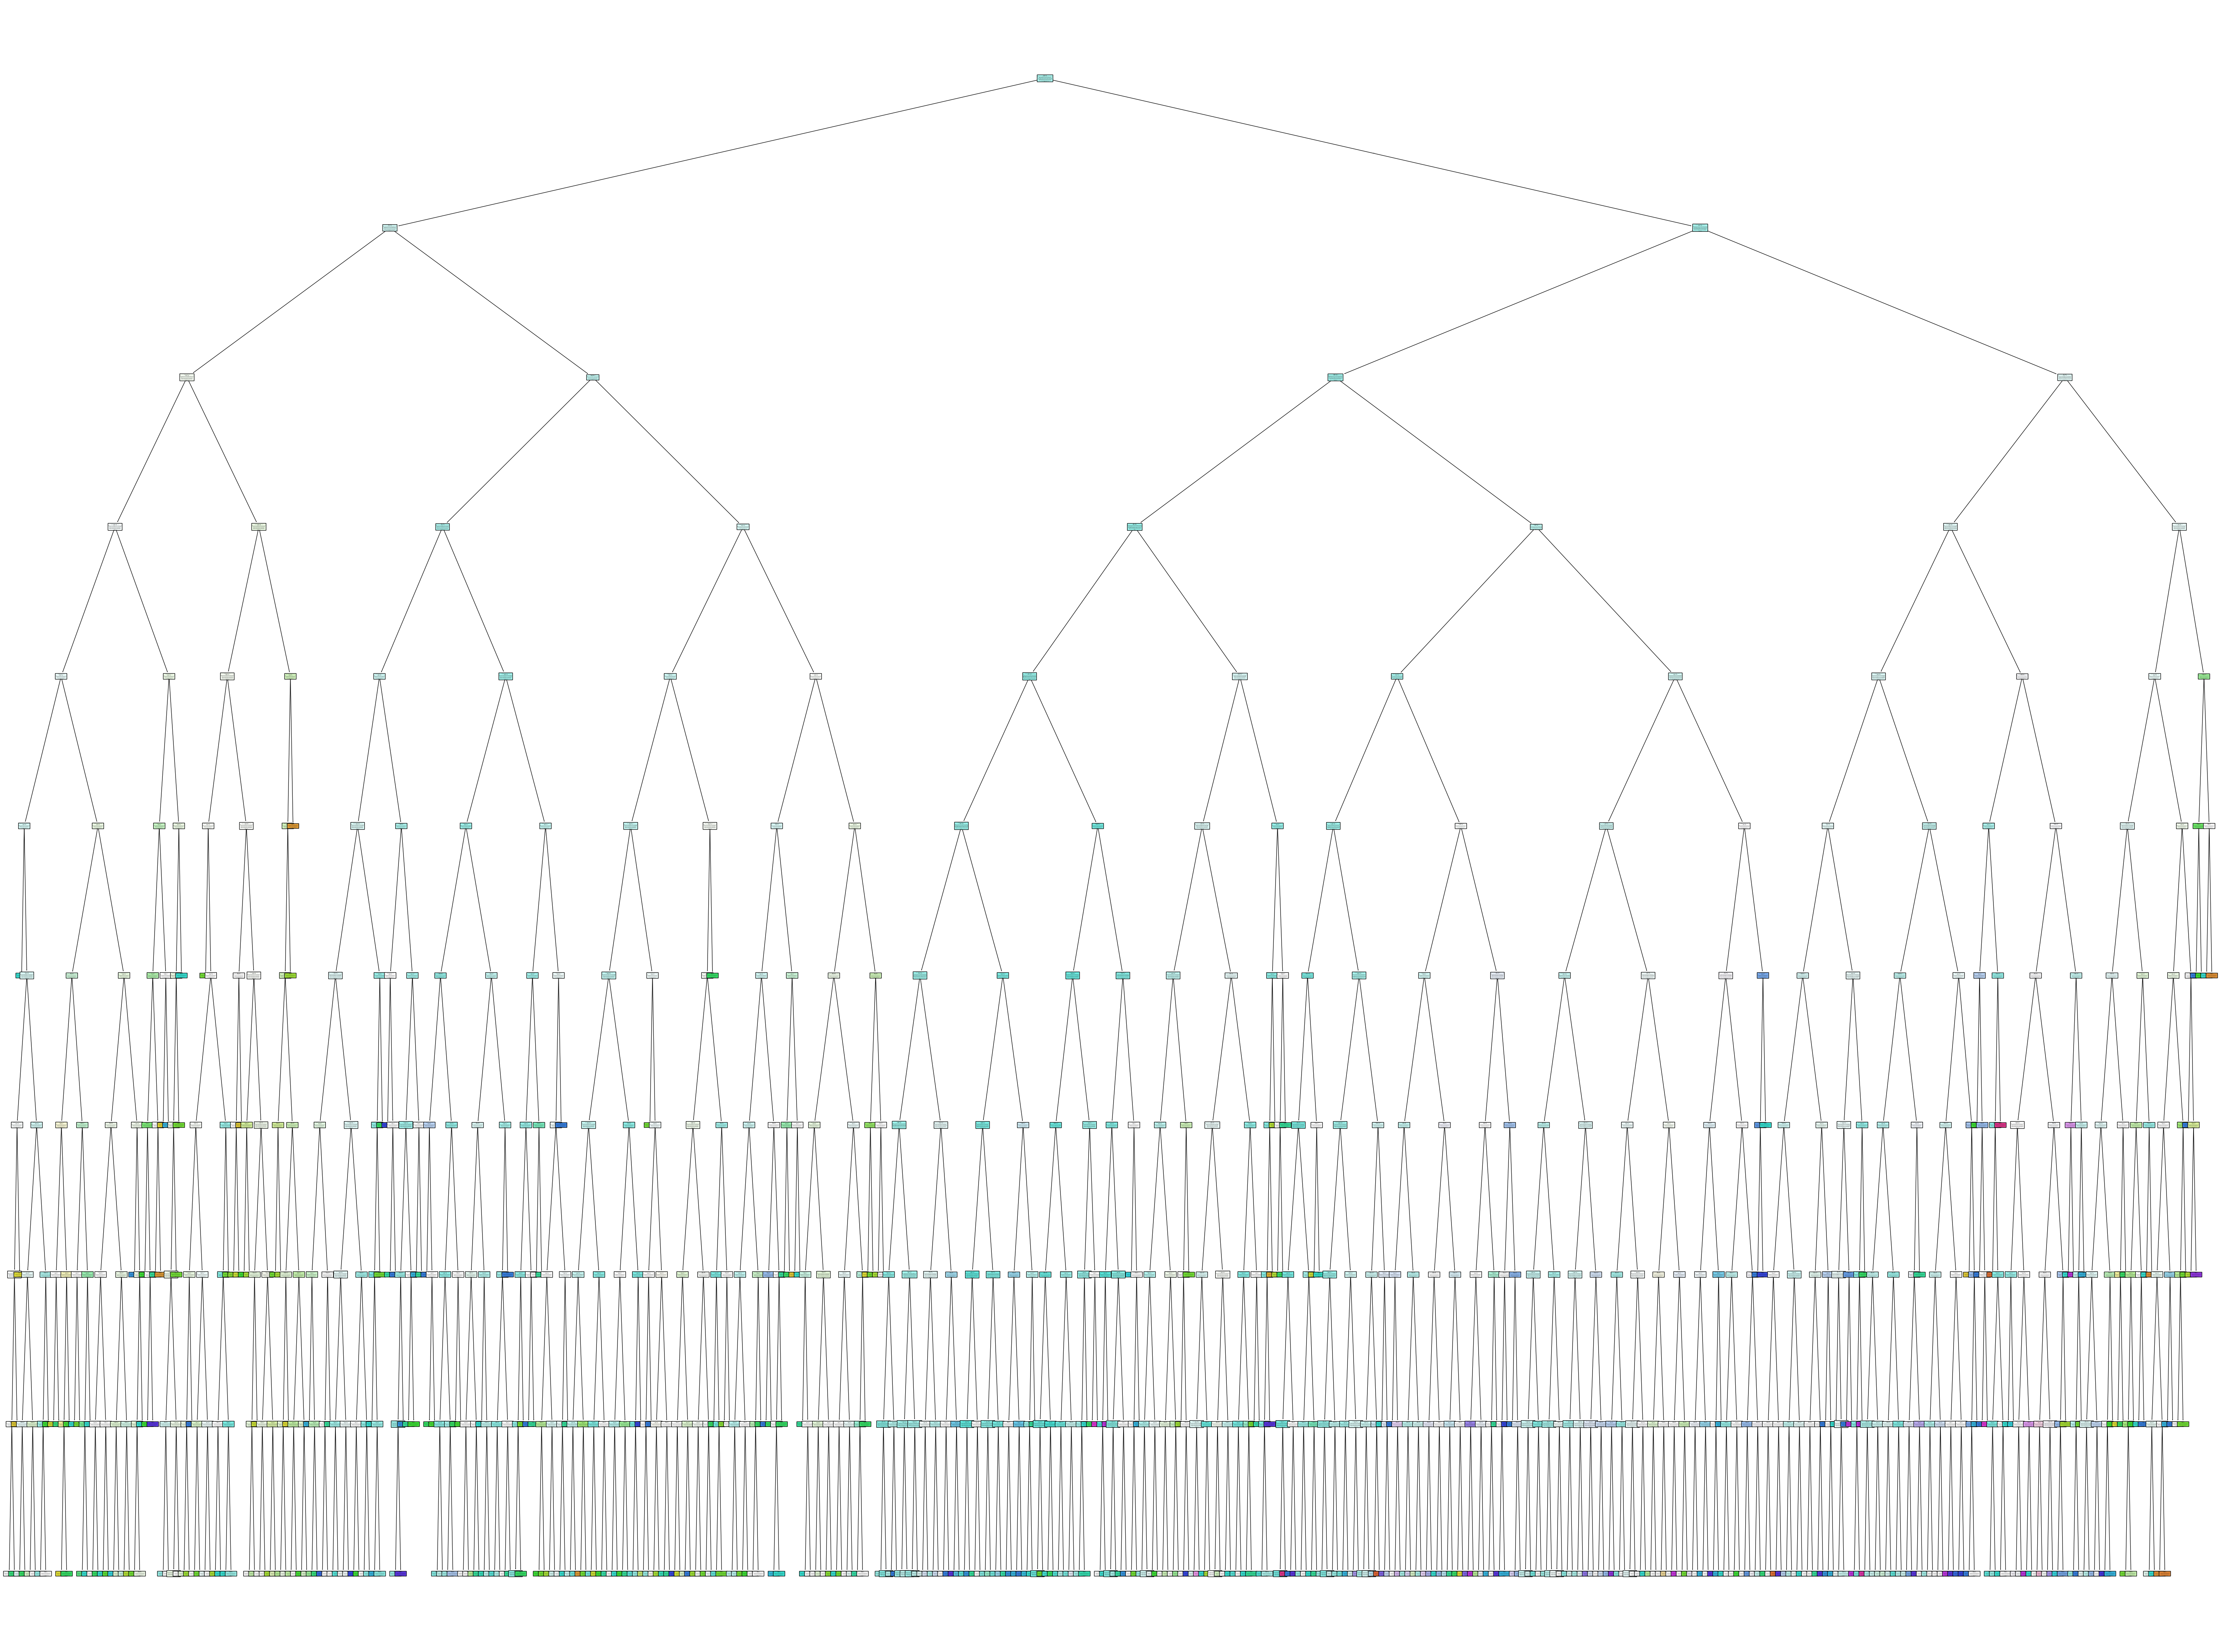

In [32]:
from sklearn.tree import plot_tree
# Визуализируем дерево решений
plt.figure(figsize=(80, 60))
plot_tree(tree_model, feature_names=X.columns, class_names=[str(item) for item in sorted(y.unique())], filled=True, rounded=True)
plt.show()
